# Security game 
Consider the security game setting described in the following. The environment to be secured is represented as a grid map, see Figure 1 below, where white cells can be traversed by a patroller, while black cells cannot be traversed. Call V the set of white cells and v a single cell. We suggest representing the environment with a binary matrix, where a white cell is associated with a 1 and a black cell with a 0. The time horizon is finite, from t = 0 to t = T, and, at every round, the patroller can move by one cell. More precisely, at every round t, the patroller can move from a cell to a neighbor cell or it can stay in the current cell. 

By exploiting an approach similar to that of the sequence form, one can use the following representation for the patroller’s strategy: call \alpha_{v, v’, t} the realization plan expressing the (unconditioned) probability with which the patroller moves from cell v’ to a neighbor v at round t. As in the sequence form, some consistency constraints are needed. In particular, in this case the sequence-form constraints are $\sum_{v’} \alpha_{v, v’, t} = \sum_{v’’} \alpha_{v’’, v, t+1}$, where $\sum_{v’} \alpha_{v, v’, t}$ is the probability that the patroller is in cell v at round t.

The environment is populated with some targets denoted with diamonds in Figure 2. The players’ utility functions are defined as in Section 4.1 of the paper titled “Computing Optimal Randomized Resource Allocations for Massive Security Games”. Notice that the probability that the patroller covers a given cell v at round t is given by $\sum_{v’} \alpha_{v, v’, t}$, where the meaning of the term “covers” is the same used in the aforementioned paper. Furthermore, the game is general-sum.

![2024-05-05 103031.png](<./2024-05-05 103031.png>)
![2024-05-05 103105.png](<./2024-05-05 103105.png>)

The available actions of the attacker are pairs (v*, t) where v* is a cell with a target. 

To model the situation in which the attacker does not know the starting cell of the patroller, assume that the patroller, at t = 0, is in a fictitious cell that is a neighbor of all the cells of the environment and that the probabilities of moving from the fictitious cell to the cells of the environment is part of the strategy. The patroller cannot move to the fictitious cell after t = 0. Furthermore, the attacker cannot attack at t = 0.

Design either a Multi-LP or a MILP program, and the corresponding MOD and DAT files, to find the Stackelberg equilibrium of the game once given the environment and the values associated with the targets.

![IMG_46334385B247-1 (1).jpeg](<./IMG_46334385B247-1 (1).jpeg>)

In [109]:
from amplpy import AMPL
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

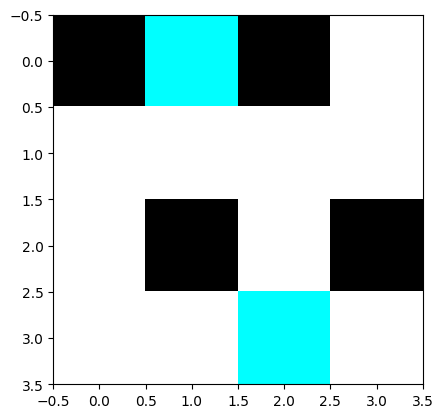

In [110]:
# Enviroment
env = [[0, 2, 0, 1],
        [1, 1, 1, 1],
        [1, 0, 1, 0],
        [1, 1, 2, 1]]

env_df = pd.DataFrame(env)

cmap = mcolors.ListedColormap(['black', 'white', 'cyan'])
plt.imshow(env_df, cmap=cmap)
plt.show()

In [111]:
# def stackleberg_equilibrium_security_game(T, V, U, TARGETS):    
#     ampl = AMPL()
#     ampl.read('security_stackleberg.mod')
    
#     ampl.set['T'] = T 
#     ampl.set['ROWS'] = list(range(V.shape[0]))
#     ampl.set['COLUMNS'] = list(range(V.shape[1]))
#     ampl.set['STATE'] = [0, 1] # Covered(0), Uncovered(1)
#     ampl.set['ROLE'] = [0, 1] # Defender(0), Attacker(1)
#     ampl.set['TARGET_ROWS'] = TARGETS['rows']
#     ampl.set['TARGET_COLUMNS'] = TARGETS['columns']
    
#     ampl.param['V'] = V
#     ampl.param['U'] = U
    
#     ampl.param['Z'] = 1000

#     ampl.solve(solver='gurobi')
#     assert ampl.solve_result == "solved"
    
#     obj = ampl.getObjective('obj').value()
#     alpha = ampl.getVariable('alpha').getValues().toPandas()
#     alpha_0 = ampl.getVariable('alpha_0').getValues().toPandas()
    
#     alpha = [alpha_0, alpha]
    
#     x = ampl.getVariable('x').getValues().toPandas()

#     ampl.close()
    
#     return obj, alpha, x

In [112]:
# # Sets
# max_time = 5
# T = range(1, max_time + 1)
# V = env_df

# # utilities
# U =  [[5, -20], # defender 
#     [-10, 30]]  # attacker
# U_df = pd.DataFrame(U, columns=[0, 1], index=[0, 1])

# # Get the rows in which there is a 2 in V 
# targets = V[V == 2].stack().index.tolist()
# TARGETS = {
#     'rows': [x[0] for x in targets],
#     'columns': [x[1] for x in targets]
# }

# U_df = pd.concat([U_df, U_df], keys=TARGETS['rows'])
# U_df = pd.concat([U_df, U_df], keys=TARGETS['columns'])

# indexes_to_drop = list(set([(j, i) for i, j, k in U_df.index.tolist()]))
# indexes_to_drop = [(i, j) for i, j in indexes_to_drop if (i,j) not in targets]
# indexes_to_drop = list(set([(j, i) for i, j in indexes_to_drop]))

# U_df.drop(indexes_to_drop, inplace=True)

# U = U_df

# obj, alpha, x = stackleberg_equilibrium_security_game(T, V, U, TARGETS)

# print('\nResults:')
# print('Objective:', obj)
# print('Alpha:', alpha)
# print('x:', x)

# Version 02: SSE for security game

In [113]:
def stackleberg_equilibrium_security_game(time, rows, cols, V, U):    
    ampl = AMPL()
    ampl.read('security_stackleberg_v2.mod')
    
    ampl.param['time'] = time
    
    ampl.param['rows'] = rows
    ampl.param['cols'] = cols
    ampl.param['V'] = V
    ampl.param['Z'] = 10000
    
    ampl.set['STATES'] = [0, 1] # Covered(0), Uncovered(1)
    ampl.set['ROLES'] = [0, 1] # Defender(0), Attacker(1)

    ampl.param['U'] = U

    ampl.solve(solver='gurobi')
    assert ampl.solve_result == "solved"
    
    obj = ampl.getObjective('obj').value()
    alpha = ampl.getVariable('alpha').getValues().toPandas()
    x = ampl.getVariable('x').getValues().toPandas()
    d = ampl.getVariable('d').value()
    k = ampl.getVariable('k').value()

    ampl.close()
    
    return obj, alpha, x, d, k

In [114]:
# Sets
time = 5 # Maximum time

# Enviroment
env = [[0, 2, 0, 1],
        [1, 1, 1, 1],
        [1, 0, 1, 0],
        [1, 1, 2, 1]]

rows = len(env)
cols = len(env[0])
V = [item for sublist in env for item in sublist]

# utilities
U =  [[5, -20], # defender 
    [-10, 30]]  # attacker
U_df = pd.DataFrame(U, columns=[0, 1], index=[0, 1])

targets_indexes = [i for i, x in enumerate(V) if x == 2]
U_df = pd.concat([U_df, U_df], keys=targets_indexes)

obj, alpha, x, d, k = stackleberg_equilibrium_security_game(time, rows, cols, V, U_df)


Gurobi 9.5.1: optimal solution; objective -20
plus 2 simplex iterations for intbasis


In [115]:
print('\nResults:')
print('Objective:', obj)
print('Expected defender utility:', d)
print('Expected attacker utility:', k)


Results:
Objective: -20.0
Expected defender utility: -20.0
Expected attacker utility: 30.0


In [116]:
print('Alpha:', alpha)

Alpha:                       alpha.val
index0 index1 index2           
-1     0      0               0
              1               0
              2               0
              3               0
              4               0
...                         ...
 15    15     1               0
              2               0
              3               0
              4               0
              5               0

[1632 rows x 1 columns]


In [117]:
print('Strategy Defender:')
for t in range(time+1):
    print('\n---------\n')
    print('Time:', t)
    filtered_df = alpha[alpha.index.map(lambda x: x[-1] == t)] 
    # print(filtered_df)
    filter_ones = filtered_df[filtered_df['alpha.val'] == 1]
    print(filter_ones)

Strategy Defender:

---------

Time: 0
                      alpha.val
index0 index1 index2           
-1     5      0               1

---------

Time: 1
                      alpha.val
index0 index1 index2           
5      1      1               1

---------

Time: 2
                      alpha.val
index0 index1 index2           
1      1      2               1

---------

Time: 3
                      alpha.val
index0 index1 index2           
1      5      3               1

---------

Time: 4
                      alpha.val
index0 index1 index2           
5      6      4               1

---------

Time: 5
                      alpha.val
index0 index1 index2           
6      6      5               1


In [118]:
print('Strategy Attacker:')
for t in range(time+1):
    print('\n---------\n')
    print('Time:', t)
    filtered_df = x[x.index.map(lambda x: x[-1] == t)] 
    filter_ones = filtered_df[filtered_df['x.val'] == 1]
    print(filter_ones)

Strategy Attacker:

---------

Time: 0
Empty DataFrame
Columns: [x.val]
Index: []

---------

Time: 1
               x.val
index0 index1       
1      1           1

---------

Time: 2
               x.val
index0 index1       
14     2           1

---------

Time: 3
               x.val
index0 index1       
14     3           1

---------

Time: 4
               x.val
index0 index1       
1      4           1

---------

Time: 5
               x.val
index0 index1       
1      5           1


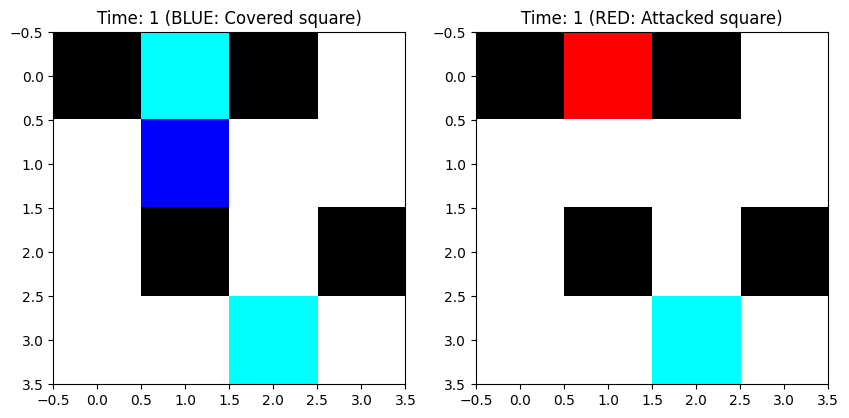

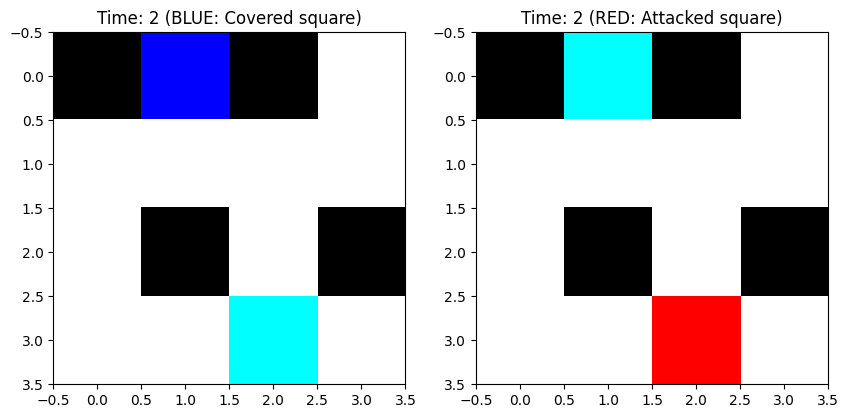

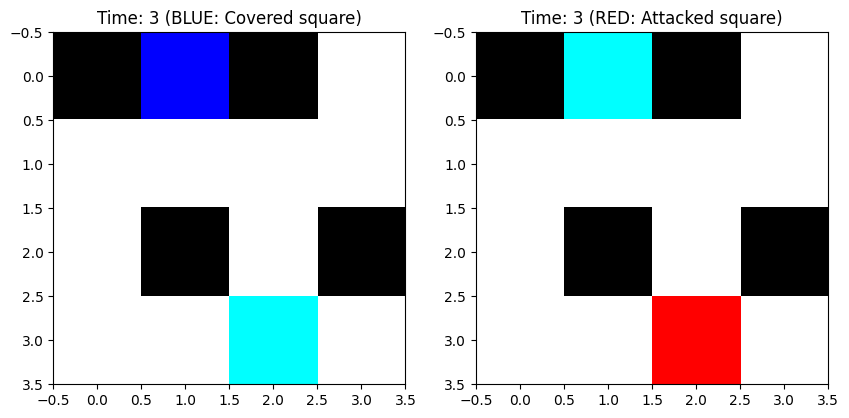

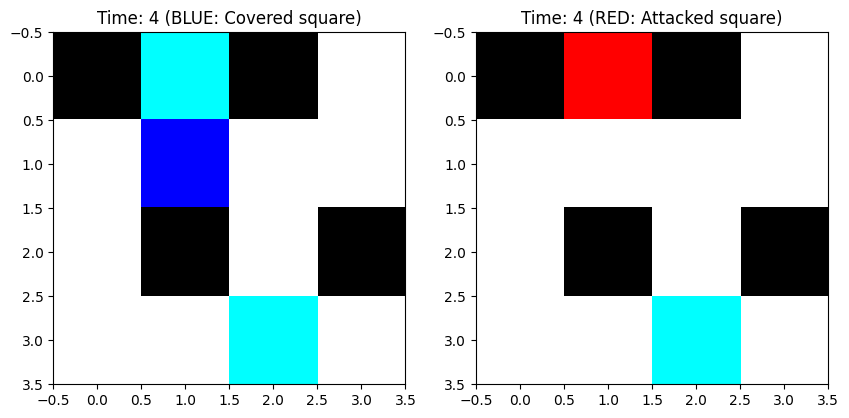

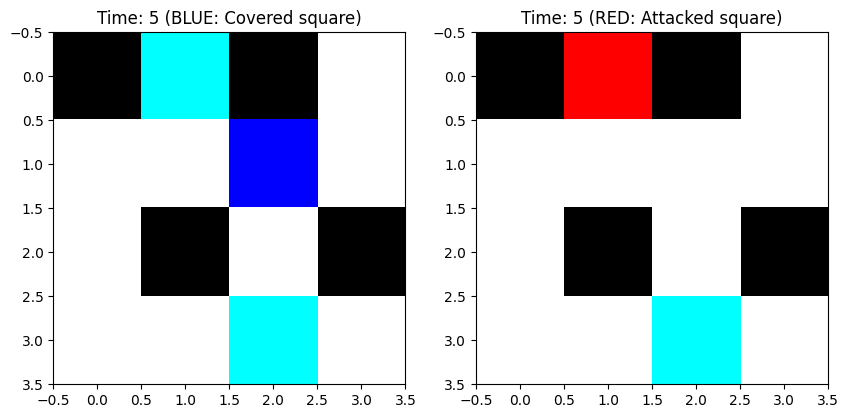

In [119]:
# Print of strategies side by side 
for t in range(1, time+1):
    env_df_d = env_df.copy()
    env_df_a = env_df.copy()
    
    filtered_df_d = alpha[alpha.index.map(lambda x: x[-1] == t)] 
    filtered_df_a = x[x.index.map(lambda x: x[-1] == t)] 
    
    covered_square = filtered_df_d[filtered_df_d['alpha.val'] == 1]
    attacked_square = filtered_df_a[filtered_df_a['x.val'] == 1]
    
    indexes_d = [i for i, j, k in covered_square.index.tolist()]
    indexes_a = [i for i, j in attacked_square.index.tolist()]
    
    env_df_d = env_df_d.values.flatten()
    env_df_a = env_df_a.values.flatten()
    
    for i in indexes_d:
        env_df_d[i] = 3
    env_df_d = env_df_d.reshape(env_df.shape)
    
    for i in indexes_a:
        env_df_a[i] = 3
    env_df_a = env_df_a.reshape(env_df.shape)
    
    cmap_d = mcolors.ListedColormap(['black', 'white', 'cyan', 'blue'])
    cmap_a = mcolors.ListedColormap(['black', 'white', 'cyan', 'red'])
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(env_df_d, cmap=cmap_d)
    ax[0].set_title(f'Time: {t} (BLUE: Covered square)')
    ax[1].imshow(env_df_a, cmap=cmap_a)
    ax[1].set_title(f'Time: {t} (RED: Attacked square)')
    plt.show()